ResNet for CIFAR10

Result for ResNet18: [Test set] Average loss: 0.0036, Accuracy: 9144/10000 (91.44%)

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Step 1:
'''
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True, 
                                 transform=transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                train=False, 
                                transform=transforms.ToTensor())
    
'''
Step 2:
'''
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


'''
Step 3
'''
model = ResNet18().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=5e-4)

'''
Step 4
'''
model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

import time
start = time.time()
for epoch in range(100) :
    print("{}th epoch starting.".format(epoch))
    for i, (images, labels) in enumerate(train_loader) :
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        optimizer.step()

    print ("Epoch [{}] Loss: {:.4f}".format(epoch+1, train_loss.item()))

end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


'''
Step 5
'''
model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

DenseNet for CIFAR10

Result for DenseNet: [Test set] Average loss: 0.0046, Accuracy: 8935/10000 (89.35%)

In [1]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Step 1:
'''
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True, 
                                 transform=transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                train=False, 
                                transform=transforms.ToTensor())

'''
Step 2:
'''
class bn_relu_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size, stride, padding, bias=False):
        super(bn_relu_conv, self).__init__()
        self.batch_norm = nn.BatchNorm2d(nin)
        self.relu = nn.ReLU(True)
        self.conv = nn.Conv2d(nin, nout, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

    def forward(self, x):
        out = self.batch_norm(x)
        out = self.relu(out)
        out = self.conv(out)

        return out

class bottleneck_layer(nn.Sequential):
    def __init__(self, nin, growth_rate, drop_rate=0.2):    
        super(bottleneck_layer, self).__init__()
        
        self.add_module('conv_1x1', bn_relu_conv(nin=nin, nout=growth_rate*4, kernel_size=1, stride=1, padding=0, bias=False))
        self.add_module('conv_3x3', bn_relu_conv(nin=growth_rate*4, nout=growth_rate, kernel_size=3, stride=1, padding=1, bias=False))
        
        self.drop_rate = drop_rate
        
    def forward(self, x):
        bottleneck_output = super(bottleneck_layer, self).forward(x)
        if self.drop_rate > 0:
            bottleneck_output = F.dropout(bottleneck_output, p=self.drop_rate, training=self.training)
        
        bottleneck_output = torch.cat((x, bottleneck_output), 1)
        
        return bottleneck_output

class Transition_layer(nn.Sequential):
    def __init__(self, nin, theta=0.5):    
        super(Transition_layer, self).__init__()
        
        self.add_module('conv_1x1', bn_relu_conv(nin=nin, nout=int(nin*theta), kernel_size=1, stride=1, padding=0, bias=False))
        self.add_module('avg_pool_2x2', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        
class DenseBlock(nn.Sequential):
    def __init__(self, nin, num_bottleneck_layers, growth_rate, drop_rate=0.2):
        super(DenseBlock, self).__init__()
        
        for i in range(num_bottleneck_layers):
            nin_bottleneck_layer = nin + growth_rate * i
            self.add_module('bottleneck_layer_%d' % i, bottleneck_layer(nin=nin_bottleneck_layer, growth_rate=growth_rate, drop_rate=drop_rate))

class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, num_layers=100, theta=0.5, drop_rate=0.2, num_classes=10):
        super(DenseNet, self).__init__()
        
        assert (num_layers - 4) % 6 == 0
        
        # (num_layers-4)//6 
        num_bottleneck_layers = (num_layers - 4) // 6
        
        # 32 x 32 x 3 --> 32 x 32 x (growth_rate*2)
        self.dense_init = nn.Conv2d(3, growth_rate*2, kernel_size=3, stride=1, padding=1, bias=True)
                
        # 32 x 32 x (growth_rate*2) --> 32 x 32 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)]
        self.dense_block_1 = DenseBlock(nin=growth_rate*2, num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)

        # 32 x 32 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)] --> 16 x 16 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)]*theta
        nin_transition_layer_1 = (growth_rate*2) + (growth_rate * num_bottleneck_layers) 
        self.transition_layer_1 = Transition_layer(nin=nin_transition_layer_1, theta=theta)
        
        # 16 x 16 x nin_transition_layer_1*theta --> 16 x 16 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)]
        self.dense_block_2 = DenseBlock(nin=int(nin_transition_layer_1*theta), num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)

        # 16 x 16 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)] --> 8 x 8 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)]*theta
        nin_transition_layer_2 = int(nin_transition_layer_1*theta) + (growth_rate * num_bottleneck_layers) 
        self.transition_layer_2 = Transition_layer(nin=nin_transition_layer_2, theta=theta)
        
        # 8 x 8 x nin_transition_layer_2*theta --> 8 x 8 x [nin_transition_layer_2*theta + (growth_rate * num_bottleneck_layers)]
        self.dense_block_3 = DenseBlock(nin=int(nin_transition_layer_2*theta), num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)
        
        nin_fc_layer = int(nin_transition_layer_2*theta) + (growth_rate * num_bottleneck_layers) 
        
        # [nin_transition_layer_2*theta + (growth_rate * num_bottleneck_layers)] --> num_classes
        self.fc_layer = nn.Linear(nin_fc_layer, num_classes)
        
    def forward(self, x):
        dense_init_output = self.dense_init(x)
        
        dense_block_1_output = self.dense_block_1(dense_init_output)
        transition_layer_1_output = self.transition_layer_1(dense_block_1_output)
        
        dense_block_2_output = self.dense_block_2(transition_layer_1_output)
        transition_layer_2_output = self.transition_layer_2(dense_block_2_output)
        
        dense_block_3_output = self.dense_block_3(transition_layer_2_output)
        
        global_avg_pool_output = F.adaptive_avg_pool2d(dense_block_3_output, (1, 1))                
        global_avg_pool_output_flat = global_avg_pool_output.view(global_avg_pool_output.size(0), -1)

        output = self.fc_layer(global_avg_pool_output_flat)
        
        return output

def DenseNetBC_100_12():
    return DenseNet(growth_rate=12, num_layers=100, theta=0.5, drop_rate=0.2, num_classes=10)

def DenseNetBC_250_24():
    return DenseNet(growth_rate=24, num_layers=250, theta=0.5, drop_rate=0.2, num_classes=10)

def DenseNetBC_190_40():
    return DenseNet(growth_rate=40, num_layers=190, theta=0.5, drop_rate=0.2, num_classes=10)


'''
Step 3
'''
model = DenseNetBC_100_12().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=5e-4)


'''
Step 4
'''
model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

import time
start = time.time()
for epoch in range(100) :
    print("{}th epoch starting.".format(epoch))
    for i, (images, labels) in enumerate(train_loader) :
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        optimizer.step()

    print ("Epoch [{}] Loss: {:.4f}".format(epoch+1, train_loss.item()))

end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


'''
Step 5
'''
model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

0it [00:00, ?it/s]

100%|█████████▉| 169795584/170498071 [00:18<00:00, 8349124.06it/s]

Extracting ./cifar_10data/cifar-10-python.tar.gz to ./cifar_10data/
0th epoch starting.


170500096it [00:29, 8349124.06it/s]                               

Epoch [1] Loss: 1.5817
1th epoch starting.
Epoch [2] Loss: 1.2445
2th epoch starting.
Epoch [3] Loss: 1.1041
3th epoch starting.
Epoch [4] Loss: 1.0481
4th epoch starting.
Epoch [5] Loss: 0.8940
5th epoch starting.
Epoch [6] Loss: 0.7874
6th epoch starting.
Epoch [7] Loss: 0.7937
7th epoch starting.
Epoch [8] Loss: 0.6094
8th epoch starting.
Epoch [9] Loss: 0.6181
9th epoch starting.
Epoch [10] Loss: 0.6462
10th epoch starting.
Epoch [11] Loss: 0.5729
11th epoch starting.
Epoch [12] Loss: 0.5776
12th epoch starting.
Epoch [13] Loss: 0.5893
13th epoch starting.
Epoch [14] Loss: 0.4495
14th epoch starting.
Epoch [15] Loss: 0.4415
15th epoch starting.
Epoch [16] Loss: 0.4775
16th epoch starting.
Epoch [17] Loss: 0.4152
17th epoch starting.
Epoch [18] Loss: 0.5614
18th epoch starting.
Epoch [19] Loss: 0.5415
19th epoch starting.
Epoch [20] Loss: 0.4509
20th epoch starting.
Epoch [21] Loss: 0.3004
21th epoch starting.
Epoch [22] Loss: 0.3325
22th epoch starting.
Epoch [23] Loss: 0.4837
23th

ResNeXt for CIFAR10

Result for DenseNet: [Test set] Average loss: 0.0040, Accuracy: 9037/10000 (90.37%)

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import torch.nn.functional as F
from collections import OrderedDict
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Step 1:
'''
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True, 
                                 transform=transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                train=False, 
                                transform=transforms.ToTensor())
    


'''
Step 2:
'''
"""
NOTICE:
    BasicBlock_B is not implemented
    BasicBlock_C is recommendation
    The full architecture consist of BasicBlock_A is not implemented.
"""



class ResBottleBlock(nn.Module):
    
    def __init__(self, in_planes, bottleneck_width=4, stride=1, expansion=1):
        super(ResBottleBlock, self).__init__()
        self.conv0=nn.Conv2d(in_planes,bottleneck_width,1,stride=1,bias=False)
        self.bn0 = nn.BatchNorm2d(bottleneck_width)
        self.conv1=nn.Conv2d(bottleneck_width,bottleneck_width,3,stride=stride,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(bottleneck_width)
        self.conv2=nn.Conv2d(bottleneck_width,expansion*in_planes,1,bias=False)
        self.bn2=nn.BatchNorm2d(expansion*in_planes)
        
        self.shortcut=nn.Sequential()
        if stride!=1 or expansion!=1:
            self.shortcut=nn.Sequential(
                nn.Conv2d(in_planes,in_planes*expansion,1,stride=stride,bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn0(self.conv0(x)))
        out = F.relu(self.bn1(self.conv1(out)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class BasicBlock_A(nn.Module):
    def __init__(self, in_planes, num_paths=32, bottleneck_width=4, expansion=1, stride=1):
        super(BasicBlock_A,self).__init__()
        self.num_paths = num_paths
        for i in range(num_paths):
            setattr(self,'path'+str(i),self._make_path(in_planes,bottleneck_width,stride,expansion))

        # self.paths=self._make_path(in_planes,bottleneck_width,stride,expansion)
        self.conv0=nn.Conv2d(in_planes*expansion,expansion*in_planes,1,stride=1,bias=False)
        self.bn0 = nn.BatchNorm2d(in_planes * expansion)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or expansion != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, in_planes * expansion, 1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = self.path0(x)
        for i in range(1,self.num_paths):
            if hasattr(self,'path'+str(i)):
                out+getattr(self,'path'+str(i))(x)
            # out+=self.paths(x)
            # getattr
        # out = torch.sum(out, dim=1)
        out = self.bn0(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    def _make_path(self, in_planes, bottleneck_width, stride, expansion):
        layers = []
        layers.append(ResBottleBlock(
            in_planes, bottleneck_width, stride, expansion))
        return nn.Sequential(*layers)




class BasicBlock_C(nn.Module):
    """
    increasing cardinality is a more effective way of 
    gaining accuracy than going deeper or wider
    """

    def __init__(self, in_planes, bottleneck_width=4, cardinality=32, stride=1, expansion=2):
        super(BasicBlock_C, self).__init__()
        inner_width = cardinality * bottleneck_width
        self.expansion = expansion
        self.basic = nn.Sequential(OrderedDict(
            [
                ('conv1_0', nn.Conv2d(in_planes, inner_width, 1, stride=1, bias=False)),
                ('bn1', nn.BatchNorm2d(inner_width)),
                ('act0', nn.ReLU()),
                ('conv3_0', nn.Conv2d(inner_width, inner_width, 3, stride=stride, padding=1, groups=cardinality, bias=False)),
                ('bn2', nn.BatchNorm2d(inner_width)),
                ('act1', nn.ReLU()),
                ('conv1_1', nn.Conv2d(inner_width, inner_width * self.expansion, 1, stride=1, bias=False)),
                ('bn3', nn.BatchNorm2d(inner_width * self.expansion))
            ]
        ))
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != inner_width * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, inner_width * self.expansion, 1, stride=stride, bias=False)
            )
        self.bn0 = nn.BatchNorm2d(self.expansion * inner_width)

    def forward(self, x):
        out = self.basic(x)
        out += self.shortcut(x)
        out = F.relu(self.bn0(out))
        return out

class ResNeXt(nn.Module):
    def __init__(self, num_blocks, cardinality, bottleneck_width, expansion=2, num_classes=10):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 64
        self.expansion = expansion
        
        self.conv0 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1)
        self.bn0 = nn.BatchNorm2d(self.in_planes)
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1=self._make_layer(num_blocks[0],1)
        self.layer2=self._make_layer(num_blocks[1],2)
        self.layer3=self._make_layer(num_blocks[2],2)
        self.layer4=self._make_layer(num_blocks[3],2)
        self.linear = nn.Linear(self.cardinality * self.bottleneck_width, num_classes)

    def forward(self, x):
        out = F.relu(self.bn0(self.conv0(x)))
        # out = self.pool0(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock_C(self.in_planes, self.bottleneck_width, self.cardinality, stride, self.expansion))
            self.in_planes = self.expansion * self.bottleneck_width * self.cardinality
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)


def resnext26_2x64d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=2, bottleneck_width=64)


def resnext26_4x32d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=4, bottleneck_width=32)


def resnext26_8x16d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=8, bottleneck_width=16)


def resnext26_16x8d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=16, bottleneck_width=8)


def resnext26_32x4d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=32, bottleneck_width=4)


def resnext26_64x2d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=32, bottleneck_width=4)


def resnext50_2x64d():
    return ResNeXt(num_blocks=[3, 4, 6, 3], cardinality=2, bottleneck_width=64)


def resnext50_32x4d():
    return ResNeXt(num_blocks=[3, 4, 6, 3], cardinality=32, bottleneck_width=4)



'''
Step 3
'''
model = resnext26_4x32d().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=5e-4)


'''
Step 4
'''
model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)


import time
start = time.time()
for epoch in range(100) :
    print("{}th epoch starting.".format(epoch))
    for i, (images, labels) in enumerate(train_loader) :
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        optimizer.step()

    print ("Epoch [{}] Loss: {:.4f}".format(epoch+1, train_loss.item()))

end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


'''
Step 5
'''
model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

Pattern synthesis

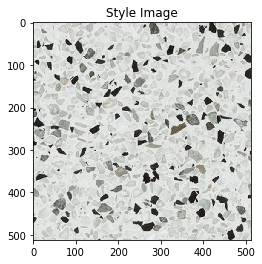

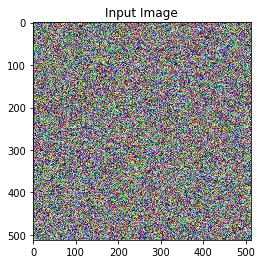

Building the style transfer model..


/home/eryu/anaconda3/envs/modelling/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/eryu/anaconda3/envs/modelling/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [100]:
Style Loss : 33.863499

run [200]:
Style Loss : 11.954251

run [300]:
Style Loss : 1.411954



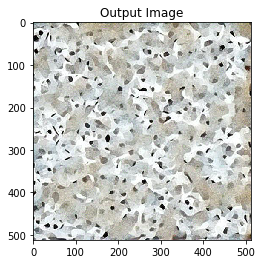

In [43]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import copy

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

    
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, 
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)


        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses


def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       style_img, input_img, num_steps=300,
                       style_weight=1000000):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0

            for sl in style_losses:
                style_score += sl.loss

            style_score *= style_weight

            loss = style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f}'.format(
                    style_score.item()))
                print()

            return style_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img


num_steps = 300
style_weight = 100000
style_img_filename = "ny.jpg"
output_img_filename = "result.jpg"


style_img = image_loader("./data/"+style_img_filename)


plt.figure()
imshow(style_img, title='Style Image')


# input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(torch.Size([1, 3, 512, 512]), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')



output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            style_img, input_img, style_weight=style_weight,
                            num_steps=num_steps)

save_image(output, './data/'+output_img_filename)
output = image_loader("./data/"+output_img_filename)
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()


Nerual Style Transfer

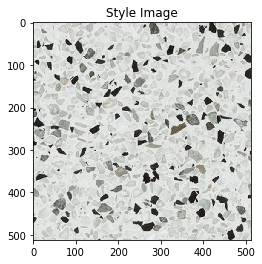

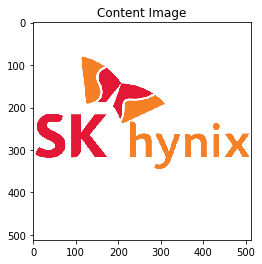

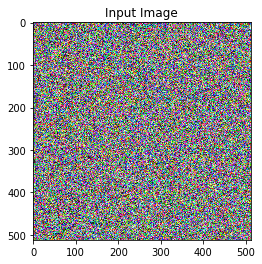

Building the style transfer model..
Optimizing..


/home/eryu/anaconda3/envs/modelling/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/eryu/anaconda3/envs/modelling/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


run [100]:
Style Loss : 3.570308 Content Loss: 2.413768

run [200]:
Style Loss : 1.448078 Content Loss: 2.096407

run [300]:
Style Loss : 0.223615 Content Loss: 1.850003

run [400]:
Style Loss : 0.135959 Content Loss: 1.712542

run [500]:
Style Loss : 0.143658 Content Loss: 1.652877

run [600]:
Style Loss : 0.142013 Content Loss: 1.636679

run [700]:
Style Loss : 4.197556 Content Loss: 1.784870



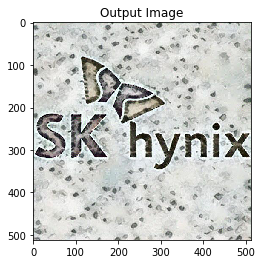

In [9]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

    
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    #switch to SGD or ADAM??
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img



num_steps = 700
style_weight = 10000
content_weight = .1
# style_img_filename = "pollock_full_fathom.jpg"
# content_img_filename = "dancing.jpg"
style_img_filename = "ny.jpg"
content_img_filename = "hynix.jpg"
output_img_filename = "result.jpg"




style_img = image_loader("./data/"+style_img_filename)
content_img = image_loader("./data/"+content_img_filename)

assert style_img.size() == style_img.size(), \
    "we need to import style and content images of the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# input_img = content_img.clone()
# input_img = style_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')



output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=style_weight,
                            num_steps=num_steps, content_weight=content_weight)

save_image(output, './data/'+output_img_filename)
output = image_loader("./data/"+output_img_filename)
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Basic data augmentation

Files already downloaded and verified


/home/eryu/anaconda3/envs/modelling/lib/python3.7/site-packages/torchvision/transforms/functional.py:440: UserWarning: torch.gels is deprecated in favour of torch.lstsq and will be removed in the next release. Please use torch.lstsq instead.
  res = torch.gels(B, A)[0]


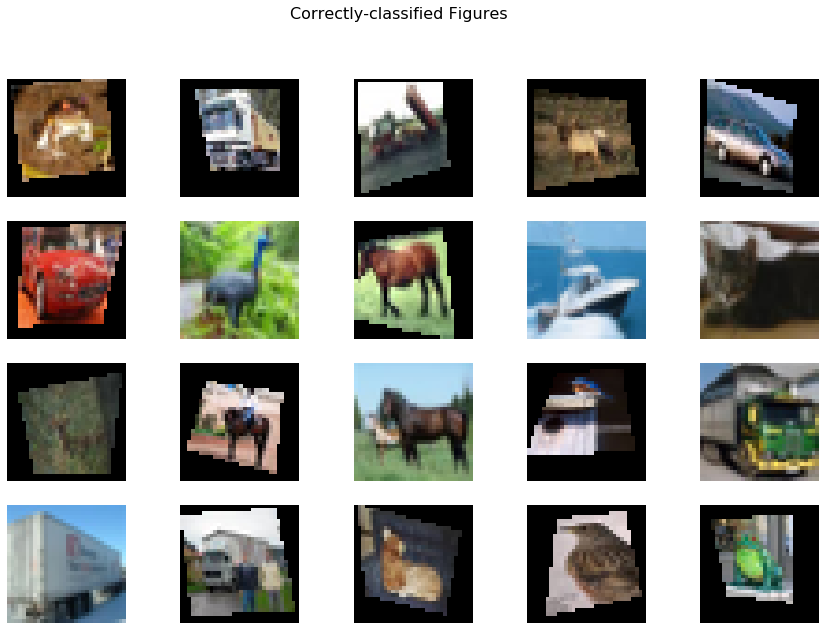

In [2]:
import torch
import torch.nn as nn
# from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt



# Image preprocessing modules
# transform = transforms.Compose([
#     transforms.Pad(4),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32),
#     transforms.ToTensor()])

# transform = transforms.Compose([
#     transforms.ColorJitter(brightness=0.8),
#     transforms.ToTensor()])

transform = transforms.Compose([
    transforms.RandomAffine(30),
    transforms.ToTensor()])

transform = transforms.Compose([
    transforms.RandomPerspective(),
    transforms.ToTensor()])


# transform = transforms.Compose([
#     transforms.RandomResizedCrop(28),
#     transforms.ToTensor()])

# transform = transforms.Compose([
#     transforms.GaussianBlur(3),
#     transforms.ToTensor()])

# transform = transforms.Compose([
#     transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
#     transforms.ToTensor()])






train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True, 
                                 transform=transform,
                                 download=True)


classes = ('plane', 'car', 'bird', 'cat',
                'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, shuffle=False)
train_loader = iter(train_loader)  # use train_loader as iteratror


fig = plt.figure(figsize=(15, 10))
fig.suptitle('Correctly-classified Figures', fontsize=16)
images, _ = next(train_loader)
for k in range(20) :
    ax = fig.add_subplot(4, 5, k+1)

    plt.imshow(images[k,:,:,:].squeeze().permute(1, 2, 0).numpy())
    plt.axis('off')

plt.show()

Mixup

Files already downloaded and verified


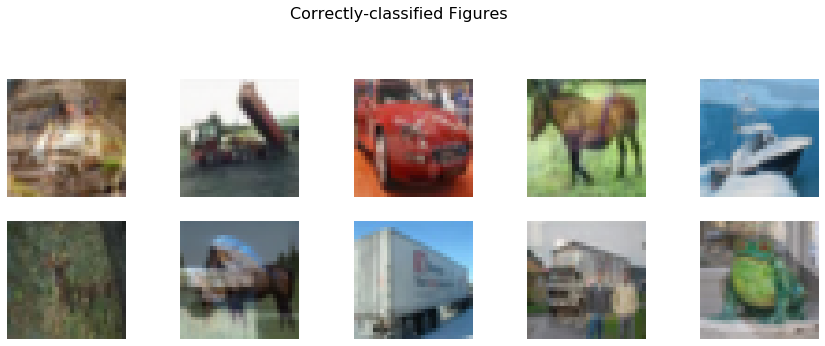

In [18]:
import torch
import torch.nn as nn
# from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy







train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)


classes = ('plane', 'car', 'bird', 'cat',
                'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, shuffle=False)
train_loader = iter(train_loader)  # use train_loader as iteratror


fig = plt.figure(figsize=(15, 10))
fig.suptitle('Correctly-classified Figures', fontsize=16)
images, labels = next(train_loader)
alpha = 1
for k in range(10) :
    lam = numpy.random.beta(alpha, alpha, size=None)
    im = (lam*images[2*k,:,:,:]+(1-lam)*images[2*k+1,:,:,:]).squeeze().permute(1, 2, 0).numpy()

    ax = fig.add_subplot(4, 5, k+1)
    
    plt.imshow(im)
    plt.axis('off')

plt.show()

Cutout

Files already downloaded and verified


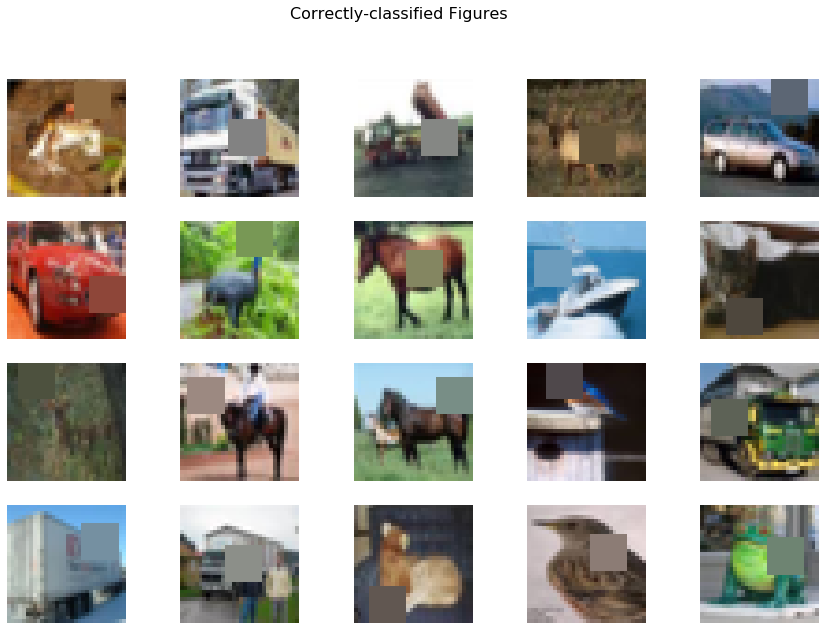

In [34]:
import torch
import torch.nn as nn
# from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy


train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)


classes = ('plane', 'car', 'bird', 'cat',
                'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, shuffle=False)
train_loader = iter(train_loader)  # use train_loader as iteratror


fig = plt.figure(figsize=(15, 10))
fig.suptitle('Correctly-classified Figures', fontsize=16)
images, labels = next(train_loader)
alpha = 1
for k in range(20) :
    ax = fig.add_subplot(4, 5, k+1)
    
    im = images[k,:,:,:].squeeze().permute(1, 2, 0).numpy().copy()
    
    w = 10
    xx = numpy.random.randint(0, 32-10+1)
    yy = numpy.random.randint(0, 32-10+1)
    
    im[xx:xx+w,yy:yy+w] = numpy.mean(im,axis=(0,1))
        
    plt.imshow(im)

    plt.axis('off')

plt.show()





CutMix

Files already downloaded and verified


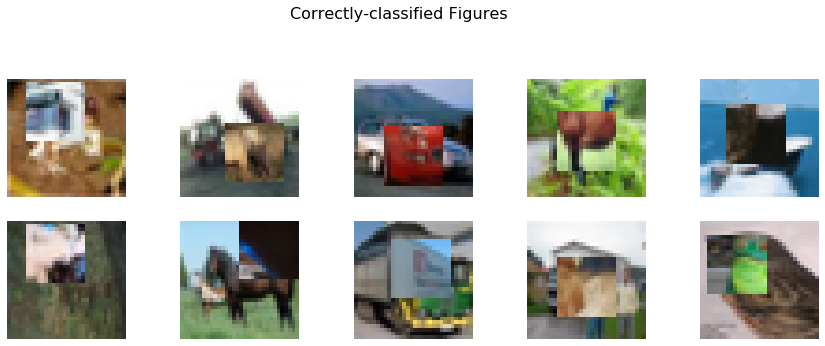

In [35]:
import torch
import torch.nn as nn
# from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy


train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)


classes = ('plane', 'car', 'bird', 'cat',
                'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, shuffle=False)
train_loader = iter(train_loader)  # use train_loader as iteratror


fig = plt.figure(figsize=(15, 10))
fig.suptitle('Correctly-classified Figures', fontsize=16)
images, labels = next(train_loader)
alpha = 1
for k in range(10) :
    ax = fig.add_subplot(4, 5, k+1)
    
    im = images[k,:,:,:].squeeze().permute(1, 2, 0).numpy().copy()
    
    w = 16
    xx = numpy.random.randint(0, 32-16+1)
    yy = numpy.random.randint(0, 32-16+1)
    
    
    
    im = images[2*k,:,:,:]
    im[:,xx:xx+w,yy:yy+w] = images[2*k+1,:,xx:xx+w,yy:yy+w]

        
    plt.imshow(im.squeeze().permute(1, 2, 0).numpy().copy())

    plt.axis('off')

plt.show()




Saliency Map via occlusion

Progress starts...
[====================] 100%

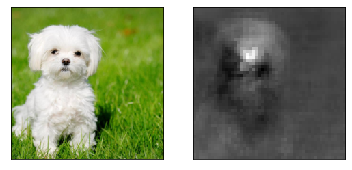

In [42]:
import sys
import torch
import torchvision
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

'''
Step 1
'''
image_file_root='./data/dog.jpg'
# image_file_root='./data/chair.jpg'
img=Image.open(image_file_root)


size=224
    
    
# preprocess the image  
image = T.Compose([
    T.CenterCrop(min(img.size)),
    T.Resize((size,size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x[None]) # This transforms image into 4-dim tensor, which is input of model
])(img)



'''
Step 2
'''
#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# we would run the model in evaluation mode
model.eval()

# label
label=model(image).argmax().item()




'''
Step 3
'''
# s=stride, k=occlusion box size
k, s= 16, 4


output_height = int(np.ceil((224-k)/s))
output_width = int(np.ceil((224-k)/s))

saliency=torch.zeros(output_width,output_height)

print('Progress starts...')
for h in range(0,52):
    for w in range(0,52):
        h_start=h*s
        w_start=w*s
        h_end=min(224,h_start+k)
        w_end=min(224,w_start+k)
        
        Occluded_input = image.clone()
        Occluded_input[:, 0, w_start:w_end, h_start:h_end] = T.ToTensor()(img).mean(dim=(1,2))[0].item()
        Occluded_input[:, 1, w_start:w_end, h_start:h_end] = T.ToTensor()(img).mean(dim=(1,2))[1].item()   
        Occluded_input[:, 2, w_start:w_end, h_start:h_end] = T.ToTensor()(img).mean(dim=(1,2))[2].item()   
        saliency[w,h] = -model(Occluded_input)[0, label]
    # percentage completion bar
    sys.stdout.write('\r')
    j=(h+1)/52
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()

    
   
'''
Step 4
'''

f, ax = plt.subplots(1,2)
# deprocessing
output= T.Compose([
    T.Lambda(lambda x: x[0]),
    T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
    T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    T.ToPILImage(),
])(image)
ax[0].imshow(output)   
ax[1].imshow(saliency, cmap='gray')
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

Saliency Map via Backprop

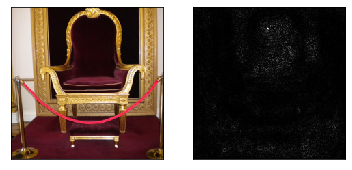

In [41]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


'''
Step 1
'''
# target example input single image from ImageNet dataset
# image_file_root='./data/dog.jpg'
image_file_root='./data/chair.jpg'
img=Image.open(image_file_root)


size=224
# preprocess the image  
image = T.Compose([
    T.CenterCrop(min(img.size)),
    T.Resize((size,size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x[None]) # This transforms image into 4-dim tensor, which is input of model
])(img)


'''
Step 2
'''
#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# we would run the model in evaluation mode
model.eval()

'''
Step 3
'''
# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
image.requires_grad_()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

scores = model(image)

# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(image.grad.data.abs(),dim=1)



'''
Step 4
'''
f, ax = plt.subplots(1,2)
# deprocessing
output= T.Compose([
    T.Lambda(lambda x: x[0]),
    T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
    T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    T.ToPILImage(),
])(image.detach())
ax[0].imshow(output)   
ax[1].imshow(saliency[0].detach(), cmap='gray')
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()